In [1]:
import numpy as np

import matplotlib.pyplot as plt

from multiprocess import Pool
from functools import partial
import numpy as np

import games

import cpb
# import cpb_uniform
import cpb_gaussian

import random_algo

import plotly.graph_objects as go

import synthetic_data
import cpb_side
import cpb_side_gaussian


import gzip
import pickle as pkl

import linucb



def evaluate_parallel(nbCores, n_folds, horizon, alg, game, type):
    print("nbCores:", nbCores, "nbFolds:", n_folds, "Horizon:", horizon)
    pool = Pool(processes = nbCores) 
    task = Evaluation(horizon, type)

    np.random.seed(1)
    distributions = []
    context_generators = []

    for jobid in range(n_folds):
        
        p = np.random.uniform(0, 0.2) if type == 'easy' else np.random.uniform(0.4,0.5)
        distributions.append( [p, 1-p] )

        d = 2
        margin =0.01
        contexts = synthetic_data.LinearContexts( np.array([0.5,0.5]), 0, d, margin) #synthetic_data.ToyContexts( )
        context_generators.append( contexts )

    return np.asarray(  pool.map( partial( task.eval_policy_once, alg, game ), zip(distributions , context_generators ,range(n_folds)) ) ) 

class Evaluation:

    def __init__(self, horizon,type ):
        self.type = type
        self.horizon = horizon
        # self.outcome_distribution = outcome_distribution

    def get_outcomes(self, game, job_id):
        # self.means = runif_in_simplex( self.game.n_outcomes )
        outcomes = np.random.choice( game.n_outcomes , p= list( game.outcome_dist.values() ), size= self.horizon) 
        return outcomes

    def get_feedback(self, game, action, outcome):
        return game.FeedbackMatrix[ action ][ outcome ]

    def get_bandit_feedback(self, game, action, outcome):
        return game.banditFeedbackMatrix[ action ][ outcome ]

    def eval_policy_once(self, alg, game, job):

        distribution, context_generator, jobid = job

        np.random.seed(jobid)

        # outcome_distribution =  {'spam':0.5,'ham':0.5}
        outcome_distribution =  {'spam':distribution[0],'ham':distribution[1]}

        game.set_outcome_distribution( outcome_distribution, jobid )
        #print('optimal action', game.i_star)

        # action_counter = np.zeros( (game.n_actions, self.horizon) )

        # generate outcomes obliviously
        outcomes = self.get_outcomes(game, jobid)
        # contexts = [ context_generator.get_context(outcome) for outcome in outcomes ]
        context_generator.generate_unique_context()
        contexts = [ context_generator.get_same_context(outcome) for outcome in outcomes ]

        cumRegret =  np.zeros(self.horizon, dtype =float)

        for t in range(self.horizon):

            if t % 10 == 0 :
                print(t)

            # Environment chooses one outcome and one context associated to this outcome
            outcome = outcomes[t]
            context = contexts[t]

            # print(context.T.shape)
            # policy chooses one action
            # print('t', t,  'outcome', outcome, 'context', context)
            action = alg.get_action(t, context)
            # print('t', t, 'action', action, 'outcome', outcome, 'context', context)
            
            feedback =  self.get_feedback( game, action, outcome )
            bandit_feedback =  self.get_bandit_feedback( game, action, outcome )

            alg.update(action, feedback, outcome, t, context )
            
            # print('nu', alg.nu / alg.n )
            regret = game.LossMatrix[action, outcome] - np.min( game.LossMatrix[...,outcome] )
            # print( 'regret:' , regret )
            cumRegret[t] =  regret
            # print()
            # print()
        # regret = np.array( [ game.delta(i) for i in range(game.n_actions) ]).T @ action_counter
        #context_regret = np.cumsum( 
        # cumRegret )

        alg.reset()

        return  np.cumsum( cumRegret ) #regret

In [10]:
import PGIDSratio

# import warnings
# warnings.filterwarnings("ignore", category=RuntimeWarning) 

n_cores = 1
n_folds = 1
horizon = 500

game =  games.apple_tasting( False ) 


alg = PGIDSratio.PGIDSratio( game, horizon, 2 )
task = Evaluation(horizon, 'difficult')

outcome_distribution = [0.4, 0.6]
d = 2
margin = 0.01
contexts_generator = synthetic_data.LinearContexts( np.array(outcome_distribution), 0, d, margin) #synthetic_data.ToyContexts( ) #
job = (outcome_distribution, contexts_generator, 4 )

result = task.eval_policy_once(alg, game, job)

# n_cores = 8
# n_folds = 8
# horizon = 1000

# result = evaluate_parallel(n_cores, n_folds, horizon, alg, game, 'easy')
# regret =  np.mean(result, 0) 
# xcoords = np.arange(0,horizon,1).tolist()
# std =  np.std(result,0) 

# plt.plot( regret )

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


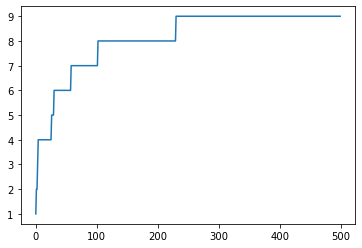

In [11]:
plt.plot(result)

In [5]:
a = np.ones((100,2))
b = np.ones(2)
c = a @ b
c.shape

(100,)

In [ ]:
import PM_DMED

n_cores = 1
n_folds = 1
horizon = 100

# np.seterr(all='raise')

# game = games.apple_tasting(False, outcome_distribution) 

outcome_distribution = [0.8,0.2]
job = (outcome_distribution, 1 )


game =  games.label_efficient(  ) 
game.set_outcome_distribution( {'spam':outcome_distribution[0],'ham':outcome_distribution[1]} )
print('optimal action', game.i_star)


# print('optimal action', game.i_star)
alg = cpb.CPB(  game, horizon,1.01) #TSPM.TSPM_alg(  game, horizon, 1)
task = Evaluation(horizon, 'easy')

result = task.eval_policy_once(alg,game, job)
#plt.plot(range(horizon), result)
# fig = go.Figure( )
# regret = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.mean(result,0) 
# xcoords = np.arange(0,horizon,1).tolist()

# fig.add_trace(go.Scatter(x=xcoords, y=regret, line=dict(color='blue'), mode='lines',  name='TPSM' )) # 


In [ ]:
n_cores = 8
n_folds = 50
horizon = 10000
# outcome_distribution =  {'spam':0.05,'ham':0.95}

game = games.label_efficient(  )
 
algos = [ PGIDSratio.PGIDSratio( game, horizon, 2 )   ]


colors = [  [0,0,0], [250,0,0], [200,0,0], [0,200,0]   ] #[0,150,0], [0,250,0], [0,150,0], [0,0,250], [0,0,0],  [0,255,0], [0 , 150, 0], [155,155,0], [255,0,0], [0,0,255] , [255,51,255], [255,51,255], [255,20,200]  ] #
labels = [  'random',  'CPB',  'RandCPB', 'TSPM'   ]  # 'random', 'TSPM' , 'TSPM (R=0)', 'RandCBP (uncoupled)','CPB uniform', ,'TSPM' , 'ucbTSPM (Auer)' 'FeedExp3 (2001)', 'FeedExp3 (2006)', 'CPB',  'eTSPM (Auer)',

fig = go.Figure( )

final_regrets = []

for alg, color, label in zip( algos, colors, labels):

    r,g,b = color
    result = evaluate_parallel(n_cores, n_folds, horizon, alg, game, 'harsch')
    final_regrets.append( result[:,-1] )
    regret =  np.mean(result, 0) 
    xcoords = np.arange(0,horizon,1).tolist()
    std =  np.std(result,0) 
    upper_regret = regret + std

    fig.add_trace(go.Scatter(x=xcoords, y=regret, line=dict(color='rgb({},{},{})'.format(r,g,b)), mode='lines',  name=label )) # 

    fig.add_trace(   go.Scatter( x=xcoords+xcoords[::-1], y=upper_regret.tolist()+regret.tolist()[::-1],  fill='toself', fillcolor='rgba({},{},{},0.2)'.format(r,g,b), 
                         line=dict(color='rgba(255,255,255,0)'),   hoverinfo="skip",  showlegend=False )  )
    
fig.show(legend=True)
fig.update_yaxes(range=[0, 30] )
fig.update_layout(legend= dict(yanchor="top",y=0.98,xanchor="left",x=0.77), autosize=False,
                  xaxis_title="Sequence", yaxis_title="Regret",  margin=go.layout.Margin( l=0,   r=0,   b=0,    t=0, ),   font=dict(size=13,) )
fig.write_image("./hard_LE.pdf")

fig.show()

final_regrets = np.array(final_regrets)
final = [ ( np.argmin(final_regrets[:,i]), i) for i in range(n_folds) ]

In [ ]:
fig.update_xaxes(type="linear")
fig.update_yaxes(range=[0, 12000] )
fig.update_layout(legend= dict(yanchor="top",y=0.98,xanchor="left",x=0.77), autosize=False,
                  xaxis_title="Sequence", yaxis_title="Regret",  margin=go.layout.Margin( l=0,   r=0,   b=0,    t=0, ),   font=dict(size=13,) )
fig.write_image("./hard_LE_log.pdf")
fig.show()

In [ ]:
n_cores = 8
n_folds = 200
horizon = 5000
# outcome_distribution =  {'spam':0.05,'ham':0.95}

game = games.label_efficient(  )

#feedexp3.FeedExp3(  game, horizon, ),
#feedexp3_v3.FeedExp3(  game, horizon, ),
#eTSPM.eTSPM_alg(  game, horizon, 1),
#TSPM.TSPM_alg(  game, horizon,), bpm.BPM(  game, horizon,  [0.5, 0.5 ], np.identity(2) ) ,

#TSPM.TSPM_alg(  game, horizon,), 
#ucbTSPM_v2.TSPM_alg(game, horizon)  

algos = [ random_algo.Random(  game, horizon, ),      
        cpb.CPB(  game, horizon, 1.01), 
        cpb_gaussian.CPB_gaussian(  game, horizon, 1.01, True, 1/16, 10),
        TSPM.TSPM_alg(  game, horizon, 1),   ] 

        #cpb_gaussian_v2.CPB_gaussian(  game, horizon, 1.01, True), 
        #cpb_gaussian_v2.CPB_gaussian(  game, horizon, 1.01, False), ]
        #cpb_gaussian_v2.CPB_gaussian(  game, horizon, 1.01),
        #TSPM.TSPM_alg(game, horizon, 1 ) ]
        #TSPM.TSPM_alg(game, horizon, 0 )   #eTSPM.eTSPM_alg(game, horizon, 1), cpb_uniform.CPB_uniform(  game, horizon, 1.01), 

colors = [  [0,0,0], [250,0,0], [200,0,0], [0,200,0]   ] #[0,150,0], [0,250,0], [0,150,0], [0,0,250], [0,0,0],  [0,255,0], [0 , 150, 0], [155,155,0], [255,0,0], [0,0,255] , [255,51,255], [255,51,255], [255,20,200]  ] #
labels = [  'random',  'CPB',  'RandCPB', 'TSPM'   ]  # 'random', 'TSPM' , 'TSPM (R=0)', 'RandCBP (uncoupled)','CPB uniform', ,'TSPM' , 'ucbTSPM (Auer)' 'FeedExp3 (2001)', 'FeedExp3 (2006)', 'CPB',  'eTSPM (Auer)',

fig = go.Figure( )

final_regrets = []

for alg, color, label in zip( algos, colors, labels):

    r,g,b = color
    result = evaluate_parallel(n_cores, n_folds, horizon, alg, game, 'easy')
    final_regrets.append( result[:,-1] )
    regret =  np.mean(result, 0) 
    xcoords = np.arange(0,horizon,1).tolist()
    std =  np.std(result,0) 
    upper_regret = regret + std

    fig.add_trace(go.Scatter(x=xcoords, y=regret, line=dict(color='rgb({},{},{})'.format(r,g,b)), mode='lines',  name=label )) # 

    fig.add_trace(   go.Scatter( x=xcoords+xcoords[::-1], y=upper_regret.tolist()+regret.tolist()[::-1],  fill='toself', fillcolor='rgba({},{},{},0.2)'.format(r,g,b), 
                         line=dict(color='rgba(255,255,255,0)'),   hoverinfo="skip",  showlegend=False )  )
    
fig.show(legend=True)
fig.update_yaxes(range=[0, 30] )
fig.update_layout(legend= dict(yanchor="top",y=0.98,xanchor="left",x=0.77), autosize=False,
                  xaxis_title="Sequence", yaxis_title="Regret",  margin=go.layout.Margin( l=0,   r=0,   b=0,    t=0, ),   font=dict(size=13,) )
fig.write_image("./easy_LE.pdf")

fig.show()

final_regrets = np.array(final_regrets)
final = [ ( np.argmin(final_regrets[:,i]), i) for i in range(n_folds) ]

In [10]:
res = []
for i in range(n_folds):
    opt = min(final_regrets[:,i])
    vec = [ j == opt for j in final_regrets[:,i] ] 
    #if vec[1]==1 and vec[2] == 1:
    #    pass
    #else:
    res.append(  vec  )

#print( np.sum( res,0) )

diff = []
for i in range(n_folds):
    if res[i][1] >= res[i][2]:
        diff.append( i )

np.random.seed(1)
distributions = []
for jobid in range(n_folds):
    p = np.random.uniform(0.4, 0.5) 
    distributions.append( [p, 1-p] )

distributions_rand = np.array([ distributions[i] for i in diff ])
distributions_cbp = np.array([ distributions[i] for i in range(n_folds) if i not in diff ])
#print( len( diff ) )
print(np.mean(distributions_rand[:,0]), np.std(distributions_rand[:,0]) )
print(np.mean(distributions_cbp[:,0]), np.std(distributions_cbp[:,0]) )


0.456154090331781 0.03132638699822154
0.43466197585846006 0.024706747598054565


In [ ]:
fig.update_xaxes(type="log")
fig.update_layout(legend= dict(yanchor="top",y=0.98,xanchor="left",x=0.77), autosize=False,
                  xaxis_title="Sequence (log-scale)", yaxis_title="Regret",  margin=go.layout.Margin( l=0,   r=0,   b=0,    t=0, ),   font=dict(size=13,) )
fig.write_image("./easy_LE_log.pdf")
fig.show()

In [5]:
fig.write_image("./easy_LE.pdf")

